In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision.utils as vutils
import datetime
from collections import namedtuple
from encoder import Encoder
from encoder_vgg19 import EncoderVGG19
from encoder_vision_transformer import EncoderVisionTransformer
from encoder_efficient_net_v2 import EncoderEfficientNetV2
from decoder import Decoder
from verifiier import Verifier
import torch.nn.functional as F

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
LATENT_SPACE_SIZE = 128
IMAGE_SIZE = 224

device = 'cuda:7'
cudas = [7, 8]
TRAIN_SPLIT = 0.9

In [3]:
def normalize_gaussian(x):
    return (x - x.mean()) / (x.std() + 0.00000001)

def normalize_minmax(x):
    x = (x - x.min())
    return x / x.max()

def random_noise(size):
    return torch.rand(size)

def normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    transform = torchvision.transforms.Normalize(mean, std)
    return transform(tensor)

In [4]:
def display_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = image.cpu()
    image = torch.clip(image * torch.FloatTensor(std) + torch.FloatTensor(mean), 0, 1)
    plt.imshow(image)
    plt.show()

In [5]:
class CelebADataset(torch.utils.data.Dataset):

    def __init__(self, dataset, identities_txt, transform):
        self.dataset = dataset
        self.transform = transform
        self.identities = {}
        self.keys = []
        with open(identities_txt) as f:
            content = f.read()
            lines = content.split('\n')
            keys = []
            for idx, line in enumerate(lines):
                # if idx >= 31384:
                #     break
                d = line.split()
                if len(d) == 2:
                    img, identity = d
                    identity = int(identity)
                    if identity not in self.identities:
                        self.identities[identity] = [idx]
                        keys.append(identity)
                    else:
                        self.identities[identity].append(idx)
            for key in keys:
                if len(self.identities[key]) == 1:
                    self.identities.pop(key)
                else:
                    self.keys.append(key)
            
        self.length = 0
        for key in self.keys:
            self.length += (len(self.identities[key]) * (len(self.identities[key]) - 1)) // 2
    
    def __len__(self):
        return 2 * self.length

    def __getitem__(self, idx):
        if idx < self.length:
            identity_idx = 0
            identity_key = self.keys[identity_idx]

            combs_for_identity = (len(self.identities[identity_key]) * (len(self.identities[identity_key]) - 1)) // 2
            
            while idx >= combs_for_identity:
                idx -= combs_for_identity
                identity_idx += 1
                identity_key = self.keys[identity_idx]
                combs_for_identity = (len(self.identities[identity_key]) * (len(self.identities[identity_key]) - 1)) // 2

            i = 0
            j = 1
            while (idx > 0):
                idx -= 1
                j += 1
                if (j == len(self.identities[identity_key])):
                    i += 1
                    j = i + 1

            pair_a = self.dataset[self.identities[identity_key][i]][0]
            pair_b = self.dataset[self.identities[identity_key][j]][0]
            label = 1
        else:
            a_key, b_key = random.sample(self.keys, 2)
            pair_a = self.dataset[random.sample(self.identities[a_key], 1)[0]][0]
            pair_b = self.dataset[random.sample(self.identities[b_key], 1)[0]][0]
            label = 0
        return self.transform(pair_a), self.transform(pair_b), label


In [6]:
class DatasetWrapper(torch.utils.data.Dataset):

    def __init__(self, dataset, idxs, transform=None):
        self.idxs = idxs
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        pair_a, pair_b, label = self.dataset[self.idxs[idx]]
        if self.transform is not None:
            return self.transform(pair_a), self.transform(pair_b), label
        else:
            return pair_a, pair_b, label


class CombineDatasetWrapper(torch.utils.data.Dataset):

    def __init__(self, datasets, transform=None):
        self.datasets = datasets
        self.transform = transform

    def __len__(self):
        return sum([len(d) for d in self.datasets])

    def __getitem__(self, idx):
        dataset_idx = 0

        while idx >= len(self.datasets[dataset_idx]):
            idx -= len(self.datasets[dataset_idx])
            dataset_idx += 1

        pair_a, pair_b, label = self.datasets[dataset_idx][idx]
        
        if self.transform is not None:
            return self.transform(pair_a), self.transform(pair_b), label
        else:
            return pair_a, pair_b, label

In [7]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation((-20, 20)),
    torchvision.transforms.TrivialAugmentWide(),
    torchvision.transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=(0.7, 1)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(196),
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(196),
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dataset = torchvision.datasets.LFWPairs(root='.data/', split='train', download=True)

perm = torch.randperm(len(dataset))
train_k = int(len(dataset) * TRAIN_SPLIT)
train_split = perm[:train_k]
val_split = perm[train_k:]

train_dataset_lfw = DatasetWrapper(dataset, train_split, train_transform)
train_dataset_celeba = CelebADataset(torchvision.datasets.CelebA(root='.data/', split='all', target_type='identity', download=True), identities_txt='.data/celeba/identity_CelebA.txt', transform=train_transform)
train_dataset_combined = CombineDatasetWrapper([train_dataset_lfw, train_dataset_celeba])
val_dataset = DatasetWrapper(dataset, val_split, val_transform)
test_dataset = torchvision.datasets.LFWPairs(root='.data/', split='test', download=True, transform=test_transform)

print('Train length (LFW): %d' % len(train_dataset_lfw))
print('Train length (CelebA): %d' % len(train_dataset_celeba))
print('Train length (Combined): %d' % len(train_dataset_combined))
print('Val length: %d' % len(val_dataset))
print('Test length: %d' % len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train length (LFW): 1980
Train length (CelebA): 4641390
Train length (Combined): 4643370
Val length: 220
Test length: 1000


In [8]:
print('Train (LFW) - Shape: %s' % (train_dataset_lfw[0][0].shape,))
print('Train (LFW) - Mean: %.4f' % train_dataset_lfw[0][0].mean())
print('Train (LFW) - Std: %.4f' % train_dataset_lfw[0][0].std())
print('Train (LFW) - Min: %.4f' % train_dataset_lfw[0][0].min())
print('Train (LFW) - Max: %.4f' % train_dataset_lfw[0][0].max())

print('Train (CelebA) - Shape: %s' % (train_dataset_celeba[0][0].shape,))
print('Train (CelebA) - Mean: %.4f' % train_dataset_celeba[0][0].mean())
print('Train (CelebA) - Std: %.4f' % train_dataset_celeba[0][0].std())
print('Train (CelebA) - Min: %.4f' % train_dataset_celeba[0][0].min())
print('Train (CelebA) - Max: %.4f' % train_dataset_celeba[0][0].max())

print('Train (Combined) - Shape: %s' % (train_dataset_combined[0][0].shape,))
print('Train (Combined) - Mean: %.4f' % train_dataset_combined[0][0].mean())
print('Train (Combined) - Std: %.4f' % train_dataset_combined[0][0].std())
print('Train (Combined) - Min: %.4f' % train_dataset_combined[0][0].min())
print('Train (Combined) - Max: %.4f' % train_dataset_combined[0][0].max())

print('Val - Shape: %s' % (val_dataset[0][0].shape,))
print('Val - Mean: %.4f' % val_dataset[0][0].mean())
print('Val - Std: %.4f' % val_dataset[0][0].std())
print('Val - Min: %.4f' % val_dataset[0][0].min())
print('Val - Max: %.4f' % val_dataset[0][0].max())

print('Test - Shape: %s' % (test_dataset[0][0].shape,))
print('Test - Mean: %.4f' % test_dataset[0][0].mean())
print('Test - Std: %.4f' % test_dataset[0][0].std())
print('Test - Min: %.4f' % test_dataset[0][0].min())
print('Test - Max: %.4f' % test_dataset[0][0].max())

Train (LFW) - Shape: torch.Size([3, 224, 224])
Train (LFW) - Mean: 0.4078
Train (LFW) - Std: 0.7440
Train (LFW) - Min: -2.1179
Train (LFW) - Max: 2.1975
Train (CelebA) - Shape: torch.Size([3, 224, 224])
Train (CelebA) - Mean: 0.4267
Train (CelebA) - Std: 1.5593
Train (CelebA) - Min: -2.1179
Train (CelebA) - Max: 2.6226
Train (Combined) - Shape: torch.Size([3, 224, 224])
Train (Combined) - Mean: 0.4528
Train (Combined) - Std: 0.6619
Train (Combined) - Min: -2.1179
Train (Combined) - Max: 2.1804
Val - Shape: torch.Size([3, 224, 224])
Val - Mean: -0.4968
Val - Std: 1.0793
Val - Min: -2.1179
Val - Max: 2.6400
Test - Shape: torch.Size([3, 224, 224])
Test - Mean: 0.0722
Test - Std: 1.2806
Test - Min: -2.1179
Test - Max: 2.6226


In [9]:
# Set random seed for reproducibility
manualSeed = int(datetime.datetime.now().timestamp() * 1000)
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1669097923169


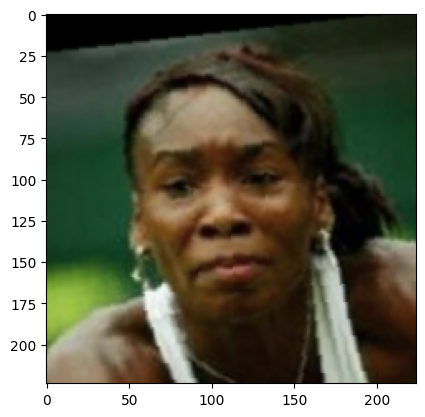

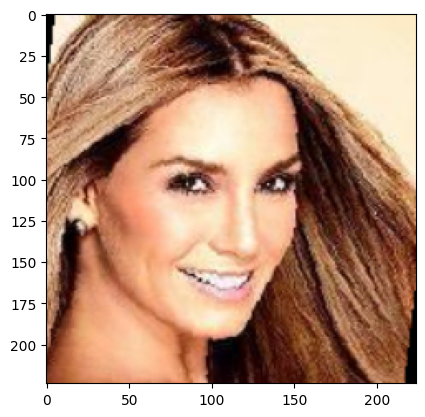

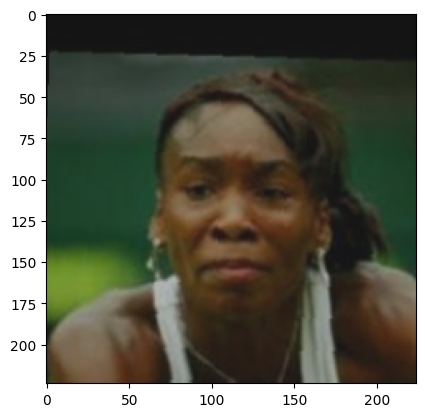

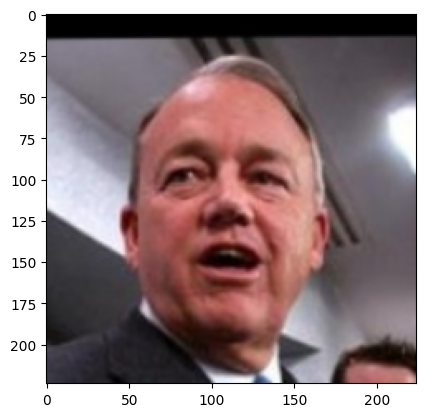

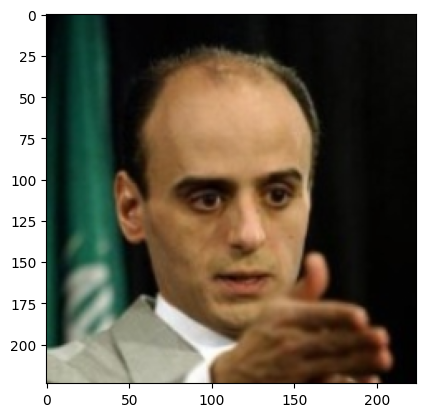

In [10]:
display_image(train_dataset_lfw[3][0].permute(1, 2, 0))
display_image(train_dataset_celeba[3][0].permute(1, 2, 0))
display_image(train_dataset_combined[3][0].permute(1, 2, 0))
display_image(val_dataset[3][0].permute(1, 2, 0))
display_image(test_dataset[3][0].permute(1, 2, 0))

In [11]:
# Create the Encoder
encoder = EncoderVisionTransformer(LATENT_SPACE_SIZE).to(device)

encoder.load_state_dict(torch.load('.models/pair/encoder-vt-224-g-combined-best-3.pt'))

# Handle multi-gpu if desired
if (len(cudas) > 1):
    encoder = torch.nn.DataParallel(encoder, cudas)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# encoder.apply(weights_init)

# Print the model
print(encoder)

AssertionError: Invalid device id

In [ ]:
# Create the Verifier
verifier = Verifier(LATENT_SPACE_SIZE).to(device)

verifier.load_state_dict(torch.load('.models/pair/verifier-224-g-combined-best-3.pt'))

# Handle multi-gpu if desired
if (len(cudas) > 1):
    verifier = torch.nn.DataParallel(verifier, cudas)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# verifier.apply(weights_init)

# Print the model
print(verifier)

DataParallel(
  (module): Verifier(
    (model): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=512, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
)


In [13]:
# Generator Code

class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = torch.nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.ConvTranspose2d(128, 512, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            torch.nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            torch.nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            torch.nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            torch.nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return (self.main(input) + 1) / 2

In [14]:
# Create the generator
generator = Generator().to(device)

generator.load_state_dict(torch.load('.models/gan/generator-2.pt', map_location=device))

# Handle multi-gpu if desired
if (len(cudas) > 1):
    generator = torch.nn.DataParallel(generator, cudas)

generator.eval()

# Print the model
print(generator)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

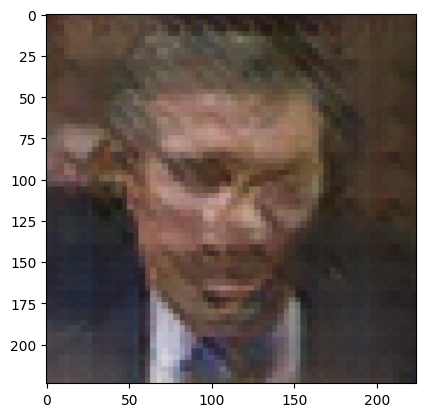

In [15]:
fake = normalize(F.interpolate(generator(torch.rand((1, 128, 1, 1), device=device)).detach(), size=224))
display_image(fake[0].permute(1, 2, 0))

In [ ]:
train_loader_combined = torch.utils.data.DataLoader(train_dataset_combined, batch_size=64, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=1)

In [ ]:
def validate():
    encoder.eval()
    verifier.eval()
    
    with torch.no_grad():
        accuracy = []
        for i, data in enumerate(val_loader, 0):

            batch_size =  data[0].size(0)

            pairs_a = data[0].to(device)
            pairs_b = data[1].to(device)
            label = data[2].float().to(device)

            ############################
            # (1) Update E and V networks for true data
            ###########################

            latent_a = torch.flatten(encoder(pairs_a), start_dim=1)
            latent_b = torch.flatten(encoder(pairs_b), start_dim=1)

            latent_diff = torch.pow(latent_a - latent_b, 2)

            output = verifier(latent_diff).view(-1)

            acc = ((output > 0.6) == (label == 1)).tolist()
            accuracy.extend(acc)

        print('Validation Accuracy: %.4f' % (sum(accuracy) / len(accuracy)))

    encoder.train()
    verifier.train()

    return sum(accuracy) / len(accuracy)

In [20]:
# Train mode
encoder.train()
verifier.train()

# Initialize BCELoss function
criterion = torch.nn.BCELoss()

# Setup Adam optimizers for both G and D

optimizerEncoder = torch.optim.Adam(encoder.parameters(), lr=0.00001, betas=(0.5, 0.999))
optimizerVerifier = torch.optim.Adam(verifier.parameters(), lr=0.00001, betas=(0.5, 0.999))

# optimizerEncoder2 = torch.optim.Adam(encoder.parameters(), lr=0.000002, betas=(0.5, 0.999))
# optimizerVerifier2 = torch.optim.Adam(verifier.parameters(), lr=0.000002, betas=(0.5, 0.999))

# optimizerEncoder1 = torch.optim.Adam(encoder.parameters(), lr=0.000001, betas=(0.5, 0.999))
# optimizerVerifier1 = torch.optim.Adam(verifier.parameters(), lr=0.000001, betas=(0.5, 0.999))

In [21]:
def train():
    # Training Loop
    num_epochs = 1000

    # Lists to keep track of progress
    iters = 0

    best = validate()

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the train_loader
        for i, data in enumerate(train_loader_combined, 0):

            batch_size = data[0].size(0)

            pairs_a = data[0].to(device)
            pairs_b = data[1].to(device)
            label = data[2].float().to(device)

            ############################
            # (1) Update using A and B
            ###########################

            optimizerEncoder.zero_grad()
            optimizerVerifier.zero_grad()

            latent_a = torch.flatten(encoder(pairs_a), start_dim=1)
            latent_b = torch.flatten(encoder(pairs_b), start_dim=1)

            latent_diff_1 = torch.pow(latent_a - latent_b, 2)
            output_1 = verifier(latent_diff_1).view(-1)
            loss_1 = criterion(output_1, label)
            acc_1 = ((output_1 > 0.5) == (label == 1)).float().mean()
            loss_1.backward()

            optimizerEncoder.step()
            optimizerVerifier.step()


            ############################
            # (2) Update using A and G
            ###########################

            # label.fill_(0)

            # optimizerEncoder1.zero_grad()
            # optimizerVerifier1.zero_grad()

            # latent_a = torch.flatten(encoder(pairs_a), start_dim=1)

            # noise = torch.randn(batch_size, 128, 1, 1, device=device)
            # fake = normalize(F.interpolate(generator(noise).detach(), size=224))
            # latent_g = torch.flatten(encoder(fake), start_dim=1)

            # latent_diff_2 = torch.pow(latent_a - latent_g, 2)
            # output_2 = verifier(latent_diff_2).view(-1)
            # loss_2 = criterion(output_2, label)
            # acc_2 = ((output_2 > 0.5) == (label == 1)).float().mean()
            # loss_2.backward(retain_graph=True)

            # optimizerEncoder1.step()
            # optimizerVerifier1.step()

            ############################
            # (3) Update using G and B
            ###########################

            # optimizerEncoder1.zero_grad()
            # optimizerVerifier1.zero_grad()

            # latent_b = torch.flatten(encoder(pairs_b), start_dim=1)
            
            # noise = torch.randn(batch_size, 128, 1, 1, device=device)
            # fake = normalize(F.interpolate(generator(noise).detach(), size=224))
            # latent_g = torch.flatten(encoder(fake), start_dim=1)

            # latent_diff_3 = torch.pow(latent_b - latent_g, 2)
            # output_3 = verifier(latent_diff_3).view(-1)
            # loss_3 = criterion(output_3, label)
            # acc_3 = ((output_3 > 0.5) == (label == 1)).float().mean()
            # loss_3.backward(retain_graph=True)
            
            # optimizerEncoder1.step()
            # optimizerVerifier1.step()

            # loss = (loss_1 + loss_2 + loss_3) / 3
            # acc = (acc_1 + acc_2 + acc_3) / 3

            # Output training stats
            if (i + 1) % 5 == 0:
                print('[%d/%d][%d/%d]\tLoss: %.4f\tAcc: %.4f'
                    % (epoch, num_epochs, (i + 1), len(train_loader_combined), loss_1.item(), acc_1.item()))
            
            if (i + 1) % 100 == 0:
                torch.save(encoder.module.state_dict(), '.models/pair/encoder-vt-224-g-combined-train.pt')
                torch.save(verifier.module.state_dict(), '.models/pair/verifier-224-g-combined-train.pt')

                acc = validate()

                print("Current best validation accuracy: %.4f" % (best,))

                if acc >= best:
                    best = acc
                    torch.save(encoder.module.state_dict(), '.models/pair/encoder-vt-224-g-combined-best-3.pt')
                    torch.save(verifier.module.state_dict(), '.models/pair/verifier-224-g-combined-best-3.pt')
                    print("Saved best model.")

            iters += 1

train()

[0/1000][32515/72553]	Loss: 0.1515	Acc: 0.9219
[0/1000][32520/72553]	Loss: 0.1796	Acc: 0.9062
[0/1000][32525/72553]	Loss: 0.1547	Acc: 0.9375
[0/1000][32530/72553]	Loss: 0.1742	Acc: 0.8906
[0/1000][32535/72553]	Loss: 0.1214	Acc: 0.9375
[0/1000][32540/72553]	Loss: 0.1467	Acc: 0.9375
[0/1000][32545/72553]	Loss: 0.2221	Acc: 0.9219
[0/1000][32550/72553]	Loss: 0.2141	Acc: 0.9219
[0/1000][32555/72553]	Loss: 0.2141	Acc: 0.9219
[0/1000][32560/72553]	Loss: 0.2731	Acc: 0.8594
[0/1000][32565/72553]	Loss: 0.1509	Acc: 0.9375
[0/1000][32570/72553]	Loss: 0.2543	Acc: 0.9062
[0/1000][32575/72553]	Loss: 0.3879	Acc: 0.7969
[0/1000][32580/72553]	Loss: 0.3587	Acc: 0.8594
[0/1000][32585/72553]	Loss: 0.2234	Acc: 0.8594
[0/1000][32590/72553]	Loss: 0.1937	Acc: 0.9219
[0/1000][32595/72553]	Loss: 0.2166	Acc: 0.8750
[0/1000][32600/72553]	Loss: 0.1961	Acc: 0.9062
Validation Accuracy: 0.9455
Current best validation accuracy: 0.9773
[0/1000][32605/72553]	Loss: 0.2839	Acc: 0.8906
[0/1000][32610/72553]	Loss: 0.2987	Acc

In [ ]:
# Create the Encoder
# encoder = EncoderVisionTransformer(LATENT_SPACE_SIZE).to(device)

# # encoder.load_state_dict(torch.load('.models/pair/encoder-vt-224-g-combined.pt'))
# encoder.load_state_dict(torch.load('.models/pair/encoder-vt-224-g-combined-best-3.pt'))

# if (len(cudas) > 1):
#     encoder = torch.nn.DataParallel(encoder, cudas)

encoder.eval()

print(encoder)

DataParallel(
  (module): EncoderVisionTransformer(
    (model): VisionTransformer(
      (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (encoder): Encoder(
        (dropout): Dropout(p=0.2, inplace=False)
        (layers): Sequential(
          (encoder_layer_0): EncoderBlock(
            (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (self_attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.2, inplace=False)
            (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): MLPBlock(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.2, inplace=False)
              (3): Linear(in_features=3072, out_features=768, bias=True)
              (4): Dropout(p=0.2, inplace=False)
         

In [ ]:
# verifier = Verifier(LATENT_SPACE_SIZE).to(device)

# # verifier.load_state_dict(torch.load('.models/pair/verifier-224-g-combined.pt'))
# verifier.load_state_dict(torch.load('.models/pair/verifier-224-g-combined-best-3.pt'))

# if (len(cudas) > 1):
#     verifier = torch.nn.DataParallel(verifier, cudas)

verifier.eval()

print(verifier)

DataParallel(
  (module): Verifier(
    (model): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=512, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
)


In [ ]:
accuracies = []

for i, data in enumerate(test_loader):
    batch_size = data[0].size(0)

    pairs_a = data[0].to(device)
    pairs_b = data[1].to(device)
    label = data[2].float().to(device)

    latent_a = torch.flatten(encoder(pairs_a), start_dim=1)
    latent_b = torch.flatten(encoder(pairs_b), start_dim=1)

    latent_diff = torch.pow(latent_a - latent_b, 2)
    output = verifier(latent_diff).view(-1)
    acc = ((output > 0.6) == (label == 1)).tolist()
    accuracies.extend(acc)

    print('Processed batch %g. Accuracy %.4f' % (i, sum(acc) / len(acc),))

Processed batch 0. Accuracy 0.9219


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 12.
Original Traceback (most recent call last):
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/azamat_bakytzhan/DL-Project/encoder_vision_transformer.py", line 15, in forward
    return self.tanh(self.model(input))
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torchvision/models/vision_transformer.py", line 298, in forward
    x = self.encoder(x)
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torchvision/models/vision_transformer.py", line 157, in forward
    return self.ln(self.layers(self.dropout(input)))
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torch/nn/modules/container.py", line 204, in forward
    input = module(input)
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torchvision/models/vision_transformer.py", line 118, in forward
    y = self.mlp(y)
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torch/nn/modules/container.py", line 204, in forward
    input = module(input)
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torch/nn/modules/activation.py", line 684, in forward
    return F.gelu(input, approximate=self.approximate)
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 74.00 MiB (GPU 12; 31.75 GiB total capacity; 10.83 GiB already allocated; 33.25 MiB free; 11.13 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [18]:
print('Overall test accuracy: %.4f' % (sum(accuracies) / len(accuracies)))

Overall test accuracy: 0.9550
